In [1]:
print("Run 2020-07-090 EfficientNet b5 on full images and respectivly reduced batch size without freezing, 200 cycles. imagenet norm")
ensembleID = '5'

runPrefix = 'alexEfficientNetB5FullImgNormImageNetOneCycle20_ENSEMBLE' + ensembleID
from fastai import *
from fastai.vision import *
from datetime import datetime
from efficientnet_pytorch import EfficientNet
import torch
import sys
import os
print("CUDA device count: " + str(torch.cuda.device_count()))
#torch.cuda.set_device(1)
print("Selected CUDA device: " + str(torch.cuda.current_device()))
print(torch.cuda.get_device_name(0))
FOLD = 1 # for test on one fold
path = '/work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds_ensemble/fold' + str(FOLD) + '/'
print("Path is: ", path)
outputDir = path + 'models_alex/' + runPrefix + '/'
print("Output dir: ", outputDir)
try:
    os.makedirs(outputDir)
except Exception:
    pass

tfms = get_transforms(flip_vert=True, max_rotate=45) # add lighting transforms!
print('Setting up ImageDataBunch...')
#EfficientNet.get_image_size(modelName)
data = ImageDataBunch.from_folder(path, bs = 16, resize_method=ResizeMethod.SQUISH, size=456, train = 'section5', valid='val', ds_tfms = tfms)

Run 2020-07-090 EfficientNet b5 on full images and respectivly reduced batch size without freezing, 200 cycles. imagenet norm


/opt/apps/resif/data/production/v1.2-20191021/default/software/lang/Python/3.7.2-GCCcore-8.2.0/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


CUDA device count: 1
Selected CUDA device: 0
Tesla V100-SXM2-32GB
Path is:  /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds_ensemble/fold1/
Output dir:  /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds_ensemble/fold1/models_alex/alexEfficientNetB5FullImgNormImageNetOneCycle20_ENSEMBLE5/
Setting up ImageDataBunch...


In [2]:
data

ImageDataBunch;

Train: LabelList (478 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
control,control,control,control,control
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds_ensemble/fold1;

Valid: LabelList (27 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
control,control,control,control,control
Path: /work/projects/hcs_ai/abottemanne/thesis/images/RGB_1_5262020/folds_ensemble/fold1;

Test: None

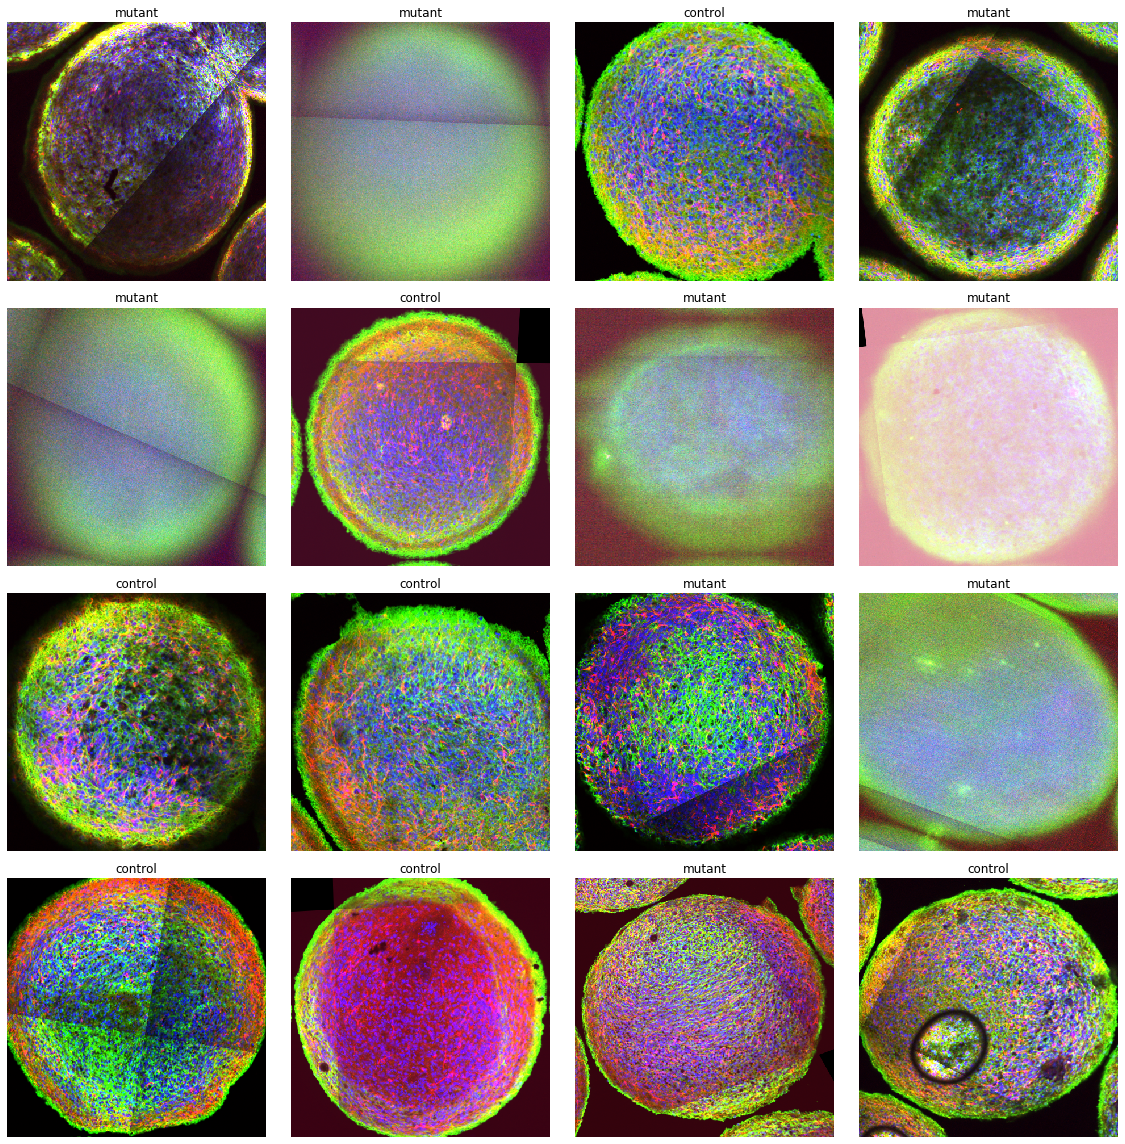

In [3]:
data.show_batch()

In [4]:
#data.normalize(imagenet_stats) # TODO make sure to normalize accordingly at inference!
data.normalize(); # TODO compare which nrom is better

In [5]:
#data.show_batch(); # TODO compare which nrom is better

In [6]:
model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=data.c)
learn = Learner(data, model, metrics = [accuracy])
learn.model_dir = outputDir

Loaded pretrained weights for efficientnet-b5


Unfreeze...
LR find...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.63E-04
Continue trainig...


Better model found at epoch 0 with accuracy value: 0.5925925970077515.
Better model found at epoch 9 with accuracy value: 0.6666666865348816.
Better model found at epoch 13 with accuracy value: 0.7037037014961243.
ClassificationInterpretation with TTA


[[11  2]
 [ 6  8]]


The validation accuracy is 70.37036895751953 %.


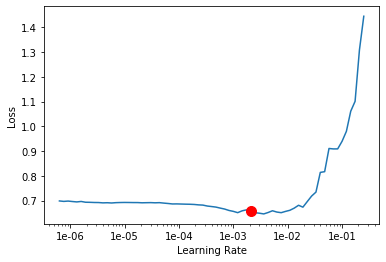

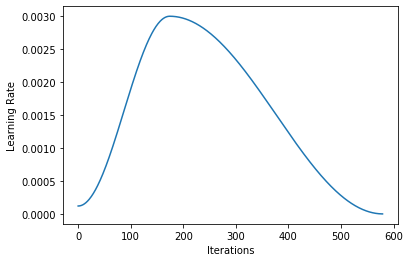

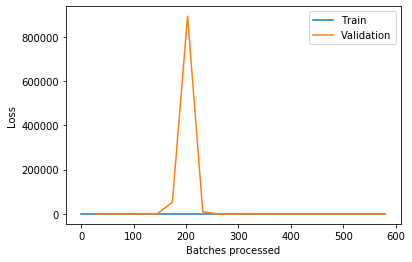

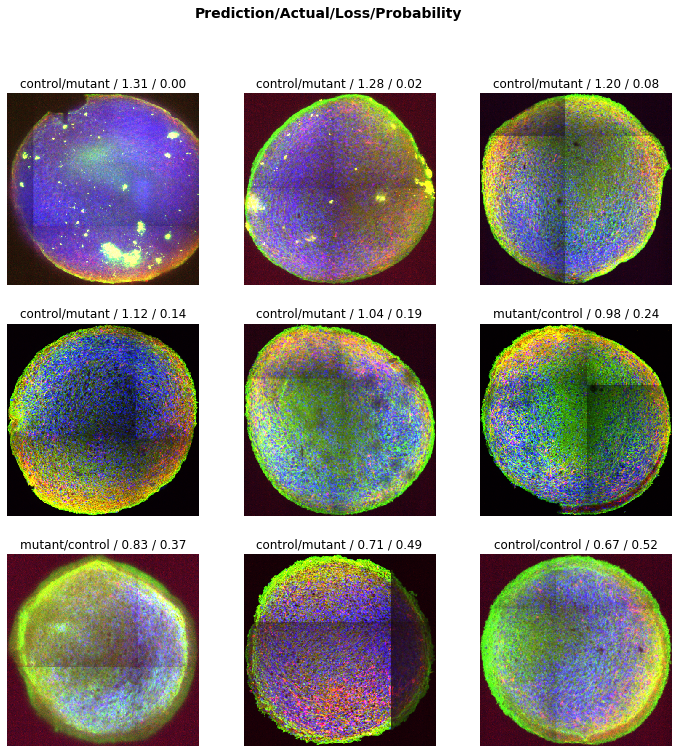

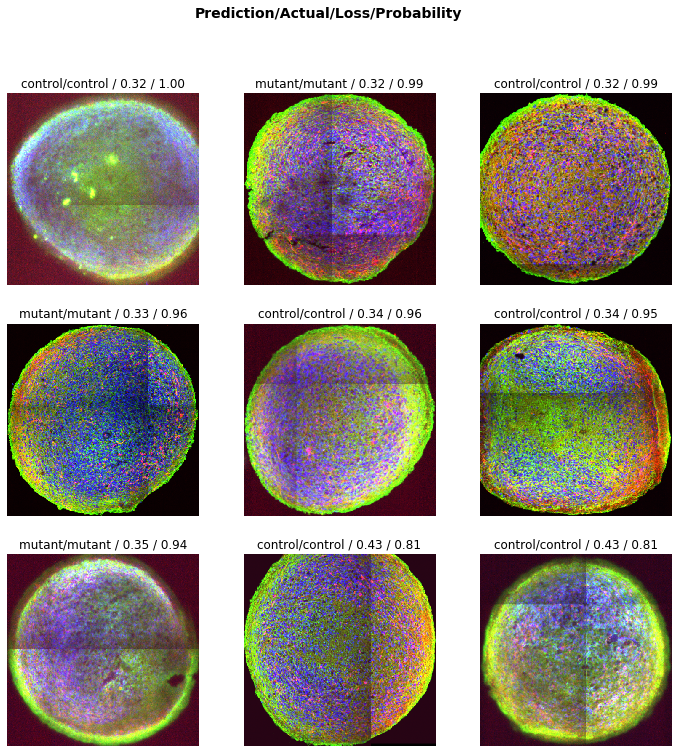

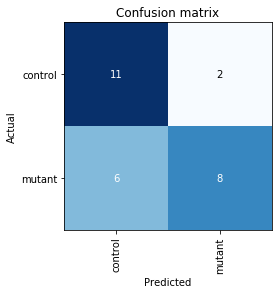

In [7]:
print('Unfreeze...')
#learn.unfreeze()
print('LR find...')
learn.lr_find()
fig = learn.recorder.plot(suggestion=True,return_fig=True)
fig.savefig(outputDir + runPrefix + 'lrfind_unfrozen.png')
suggested_lr = learn.recorder.min_grad_lr
print('Continue trainig...')
# train using fit one cycle policy, autosave the model with the best validation accuracy, overwirte it when there is a
# n improvement (i.e. keep the single best)
myCbs=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name = runPrefix + 'BestModel')]
learn.fit_one_cycle(20,callbacks=myCbs) #,suggested_lr)
fig = learn.recorder.plot_lr(return_fig=True) #plot plots LR vs loss
fig.savefig(outputDir + runPrefix + 'train_lr_unfrozen.png')
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig(outputDir + runPrefix + 'train_losses_unfrozen.png')
## vs learn.fit
#learn.fit_one_cycle(20,max_lr = slice(1e-6,3e-4))
learn.save(outputDir + runPrefix + "LastModel" )
learn.export(outputDir + runPrefix + "LastModelExport")
print('ClassificationInterpretation with TTA')
interp = ClassificationInterpretation.from_learner(learn, tta=True)
print(str(interp.confusion_matrix()))
pFlop9 = interp.plot_top_losses(9,return_fig=True)
#pFlop9Heatmap = interp.plot_top_losses(9,heatmap=True,return_fig=True)
pTop9 = interp.plot_top_losses(9,return_fig=True, largest=False)
#pTop9Heatmap = interp.plot_top_losses(9,heatmap=True,return_fig=True, largest=False)
pConfMat = interp.plot_confusion_matrix(return_fig=True)
pTop9.savefig(outputDir + runPrefix + 'top9.png')
#pTop9Heatmap.savefig(path + 'top9heatmap.png')
pFlop9.savefig(outputDir + runPrefix + 'flop9.png')
#pFlop9Heatmap.savefig(path + 'flop9heatmap.png')
pConfMat.savefig(outputDir + runPrefix + 'confmat.png')
preds,y = learn.TTA() # TTA should apply specified crop transforms (but not crop_pad!) so it should be okay
acc = accuracy(preds, y)
print('The validation accuracy is {} %.'.format(acc * 100))